# Changelog:

* 1.2 (2018.06.04)
 - Change threshold
* 1.1 (2018.03.14) 
 - Add NLM filtering
* 1.0 (2017.02.01) 
 - First automation version.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
import os

import pylab as plt
import numpy as np
import numexpr as ne
import cv2
import time
import astra
import tomopy
import requests, json
import imp
import configparser
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage.measure import compare_psnr
from skimage.transform import resize

In [3]:
plt.viridis();

In [4]:
config = configparser.ConfigParser()
config.read('tomo.ini')
experiment_id = config['SAMPLE']['_id']
print(experiment_id)

3594d54a-060a-480c-b258-48e73ea047e6


In [5]:
# import sys
# sys.path.insert(0,'/home/makov/workspace/tomography_scripts/tomo/rbtm')
# experiment_id = 'edba59e6-6442-4b9f-8e5b-2444cbf8e8a3'

In [6]:
import tomotools

In [7]:
data_dir = '/diskmnt/fast/makov/robotom/'

tmp_dir = os.path.join(data_dir, experiment_id)
tomotools.mkdir_p(tmp_dir)
data_file = tomotools.get_experiment_hdf5(experiment_id, data_dir)


INFO:root:Output experiment HDF5 file: /diskmnt/fast/makov/robotom/3594d54a-060a-480c-b258-48e73ea047e6.h5
INFO:root:Downloading file: http://10.0.7.153:5006/storage/experiments/3594d54a-060a-480c-b258-48e73ea047e6.h5
INFO:root:Successfully downloaded: http://10.0.7.153:5006/storage/experiments/3594d54a-060a-480c-b258-48e73ea047e6.h5


In [8]:
empty_images, empty_angles = tomotools.get_frame_group(data_file, 'empty', tmp_dir)
dark_images, dark_angles = tomotools.get_frame_group(data_file, 'dark', tmp_dir)

empty_image = np.median(empty_images,axis=0) 
dark_image = np.median(dark_images,axis=0)


empty_beam = empty_image - dark_image


mask = empty_beam > 0.01

# Загружаем кадры с даннымии
#TODO: добавить поддержку, когда много кадров на одном угле
data_images, data_angles = tomotools.get_frame_group(data_file, 'data', tmp_dir)

data_images_clear, _  = tomotools.load_create_mm(os.path.join(tmp_dir,'data_images_clear.tmp'),
                        shape=data_images.shape,dtype='float32')

ne.evaluate('data_images - dark_image', out = data_images_clear);

A Jupyter Widget

INFO:root:Creating new file: /diskmnt/fast/makov/robotom/3594d54a-060a-480c-b258-48e73ea047e6/group_empty.tmp
INFO:root:Creating new file: /diskmnt/fast/makov/robotom/3594d54a-060a-480c-b258-48e73ea047e6/group_empty_angles.tmp


A Jupyter Widget

INFO:root:Creating new file: /diskmnt/fast/makov/robotom/3594d54a-060a-480c-b258-48e73ea047e6/group_dark.tmp
INFO:root:Creating new file: /diskmnt/fast/makov/robotom/3594d54a-060a-480c-b258-48e73ea047e6/group_dark_angles.tmp


A Jupyter Widget

INFO:root:Creating new file: /diskmnt/fast/makov/robotom/3594d54a-060a-480c-b258-48e73ea047e6/group_data.tmp
INFO:root:Creating new file: /diskmnt/fast/makov/robotom/3594d54a-060a-480c-b258-48e73ea047e6/group_data_angles.tmp
INFO:root:Creating new file: /diskmnt/fast/makov/robotom/3594d54a-060a-480c-b258-48e73ea047e6/data_images_clear.tmp


Text(0.5,1,'Dark beam')

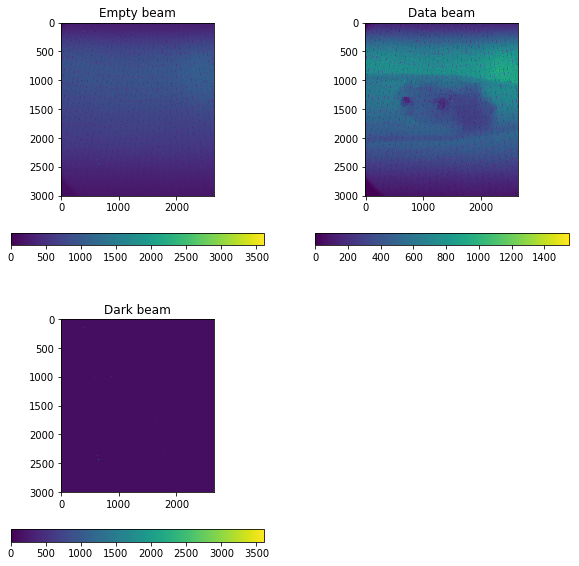

In [9]:
plt.figure(figsize=(10,10))
plt.subplot(221)
plt.imshow(empty_image, vmin=0, interpolation='nearest')
plt.colorbar(orientation='horizontal')
plt.title('Empty beam')

plt.subplot(222)
plt.imshow(data_images_clear[0], vmin=0, interpolation='nearest')
plt.colorbar(orientation='horizontal')
plt.title('Data beam')


plt.subplot(223)
plt.imshow(dark_image, vmin=0, interpolation='nearest')
plt.colorbar(orientation='horizontal')
plt.title('Dark beam')


# plt.subplot(224)
# plt.imshow(mask.astype('int'), interpolation='nearest')
# # plt.colorbar(orientation='horizontal')
# plt.title('Mask')
# #TODO: Check thresshold automaticaly
# # plt.plot([sum(empty_beam > i) for i in np.arange(100)])

In [10]:
del data_images
# del data_angles
del empty_image
del empty_images
del dark_images
del dark_image


In [11]:
data_std = np.std(data_images_clear,axis=0)
data_std = cv2.medianBlur(data_std,3)
data_mean = np.mean(data_images_clear,axis=0)
data_mean = cv2.medianBlur(data_mean,3)
data_mean[data_mean<=1] = 1

57


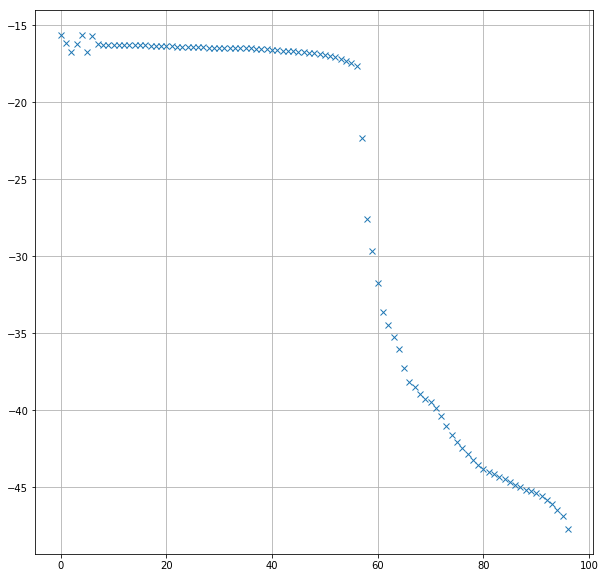

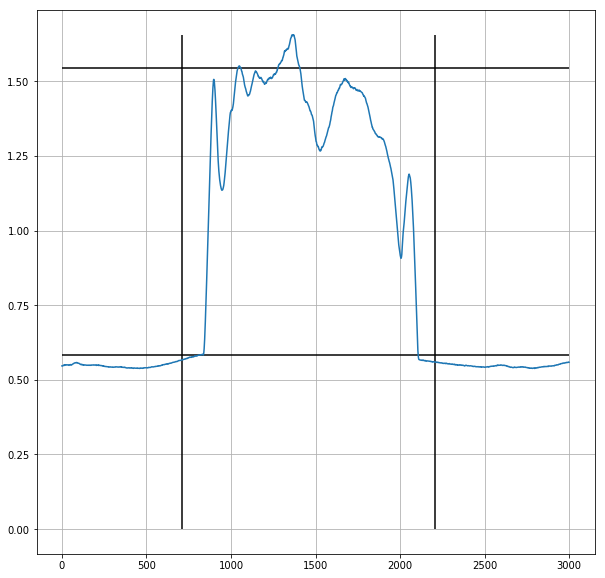

In [12]:
k  = data_std.sum(axis=-1)/(data_mean**0.5).sum(axis=-1)

curve = []
for i in range(1,99):
    curve.append(k[k>np.percentile(k,i)].sum())
    
kd = np.diff(curve)
# kd = kd-kd[0]

# thrh_d = kd[0:10].mean()
thrh_d = (kd[0]+kd[-1])/3.
thrh_pos = np.min(np.argwhere(kd[11:]<thrh_d))+11
thrh = np.percentile(k,thrh_pos)

x_min = np.min(np.argwhere(k>thrh))
x_min = np.max([200, x_min-100])
x_max = np.max(np.argwhere(k>thrh))
x_max = np.min([len(k)-200, x_max+100])

print(thrh_pos)
plt.figure(figsize=(10,10))
plt.plot(kd,'x')

plt.grid()

plt.figure(figsize=(10,10))
plt.plot(k)
plt.hlines(np.percentile(k,thrh_pos),0,len(k))
# plt.hlines(thrh,0,3000)
plt.hlines(np.percentile(k,95),0,len(k))
plt.vlines([x_min, x_max], 0,k.max())
# plt.plot(data_std.sum(axis=-1))
# plt.plot(data_mean.sum(axis=-1))
# plt.plot(data_max.sum(axis=-1))
plt.grid()



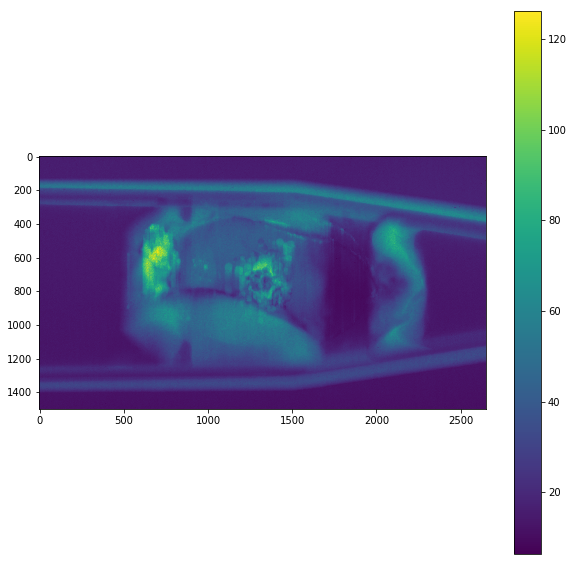

In [13]:
plt.figure(figsize=(10,10))
plt.imshow(data_std[x_min:x_max,:], interpolation='nearest')
plt.colorbar()

In [14]:
# def crop_mask(mask, up, bottom, left, right):
#     threshold = 100
#     mask_x_profile = mask.sum(axis=1)
#     mask_x_min = np.argwhere(mask_x_profile>threshold).min()+up # up border
#     mask_x_max = np.argwhere(mask_x_profile>threshold).max()-bottom # bottom border

#     mask_y_profile = mask.sum(axis=0)
#     mask_y_min = np.argwhere(mask_y_profile>threshold).min()+left # left border
#     mask_y_max = np.argwhere(mask_y_profile>threshold).max()-right # right border
#     return  mask_x_min, mask_x_max, mask_y_min, mask_y_max

INFO:root:Force create
INFO:root:Creating new file: /diskmnt/fast/makov/robotom/3594d54a-060a-480c-b258-48e73ea047e6/data_images_masked.tmp
INFO:root:Force create
INFO:root:Creating new file: /diskmnt/fast/makov/robotom/3594d54a-060a-480c-b258-48e73ea047e6/empty_images_masked.tmp


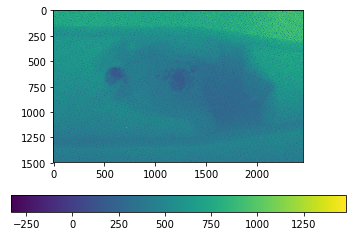

In [15]:
# mask_x_min, mask_x_max, mask_y_min, mask_y_max = crop_mask(mask, 400, 400, 100, 100)

mask_x_min, mask_x_max, mask_y_min, mask_y_max = x_min, x_max, 100, mask.shape[1]-100
mask_new = np.copy(mask[mask_x_min:mask_x_max,mask_y_min:mask_y_max])
# empty_beam = empty_beam[mask_x_min:mask_x_max,mask_y_min:mask_y_max]
## FIX IT
# data_images_croped = data_images_croped[:, mask_x_min:mask_x_max,mask_y_min:mask_y_max]

data_images_masked, _ = tomotools.load_create_mm(os.path.join(tmp_dir,'data_images_masked.tmp'),
                                   shape = (data_angles.shape[0],
                                           mask_new.shape[0], mask_new.shape[1]), dtype='float32',
                                   force_create=True)

empty_masked, _ = tomotools.load_create_mm(os.path.join(tmp_dir,'empty_images_masked.tmp'),
                                   shape = (mask_new.shape[0], mask_new.shape[1]), dtype='float32',
                                   force_create=True)

empty_masked[:] = empty_beam[mask_x_min:mask_x_max,mask_y_min:mask_y_max]


plt.figure()
plt.imshow(data_images_clear[0, mask_x_min:mask_x_max,mask_y_min:mask_y_max], interpolation='nearest')
plt.colorbar(orientation='horizontal')

for di in range(data_images_masked.shape[0]):
    data_images_masked[di] = data_images_clear[di, mask_x_min:mask_x_max,mask_y_min:mask_y_max]
#     data_images_masked[di] = cv2.medianBlur(data_images_masked[di],3)

In [16]:
# plt.figure(figsize=(10,10))
# plt.imshow(data_images_masked[:,:,501]/empty_masked[:,501], cmap=plt.cm.viridis, interpolation='nearest')
# plt.axis('tight')
# plt.colorbar(orientation='horizontal')

In [17]:
del empty_beam
del data_images_clear

In [18]:
def group_data(data_images,data_angles,  mmap_file_dir):
    uniq_angles,_ = tomotools.load_create_mm(
        os.path.join(mmap_file_dir,'uniq_angles.tmp'),
        shape=(len(list(set(data_angles))),),
        dtype='float32',force_create=True)
    uniq_angles[:] = list(set(data_angles))
    
    uniq_data_images,_ = tomotools.load_create_mm(
        os.path.join(mmap_file_dir,'uniq_data_images.tmp'),
        shape=(len(uniq_angles), data_images.shape[1], data_images.shape[2]),
        dtype='float32',force_create=True)

    for ua_id, ua in enumerate(uniq_angles):
        indexes = np.argwhere(data_angles==uniq_angles[ua_id])
        if len(indexes)>1:
            tmp_images = data_images[indexes]
            tmp_images = np.squeeze(tmp_images)
            mean_image = np.mean(tmp_images, axis=0)
            uniq_data_images[ua_id] = mean_image
        else:
            uniq_data_images[ua_id]=data_images[indexes]
    return uniq_data_images, uniq_angles

uniq_data_images, uniq_angles = group_data(data_images_masked, data_angles, tmp_dir)
del data_images_masked, data_angles

INFO:root:Force create
INFO:root:Creating new file: /diskmnt/fast/makov/robotom/3594d54a-060a-480c-b258-48e73ea047e6/uniq_angles.tmp
INFO:root:Force create
INFO:root:Creating new file: /diskmnt/fast/makov/robotom/3594d54a-060a-480c-b258-48e73ea047e6/uniq_data_images.tmp


In [19]:
#normalize data frames and calculate sinograms
# empty_masked[empty_masked <= 0] = 1e-9

for di in range(uniq_data_images.shape[0]):
    t = uniq_data_images[di]
    t = t/empty_masked
    t[t<1e-8] = 1e-8
    t[t>1] = 1
    uniq_data_images[di] = cv2.medianBlur(t,3)
#     t[t<1e-8] = 1e-8
#     t[t>1] = 1

del empty_masked

In [20]:
sinogram, _ = tomotools.load_create_mm(os.path.join(tmp_dir, 'sinogram.tmp'), shape=uniq_data_images.shape,
                         dtype='float32') 
ne.evaluate('-log(uniq_data_images)', out=sinogram);  

INFO:root:Creating new file: /diskmnt/fast/makov/robotom/3594d54a-060a-480c-b258-48e73ea047e6/sinogram.tmp


In [21]:
# sinogram /= np.float32(9e-3)**2 # Normalize to pixel size

In [22]:
# plt.figure(figsize=(7,5))
# plt.imshow(uniq_data_images[np.argsort(uniq_angles),:,int(sinogram.shape[-1]/1.75)])
# plt.axis('tight')
# # plt.colorbar()

In [23]:
del uniq_data_images

In [24]:
# # build frames for video
# images_dir = os.path.join(tmp_dir,'images')
# tomotools.mkdir_p(images_dir)
# im_max=np.max(sinogram)
# im_min=np.min(sinogram)
# print(im_min, im_max)
# for ia, a in tomotools.log_progress(list(enumerate(np.argsort(uniq_angles)))):
# #     print('{:34}'.format(ia))
#     plt.imsave(os.path.join(images_dir,'prj_{:03}.png'.format(ia)),
#                np.rot90(sinogram[a],3), vmin=im_min, vmax=im_max,
#                cmap=plt.cm.gray_r)

In [25]:
# !cd {images_dir} && avconv -r 10 -i "prj_%03d.png" -b:v 1000k prj.avi

In [26]:
# !cd {images_dir} && rm prj.mp4

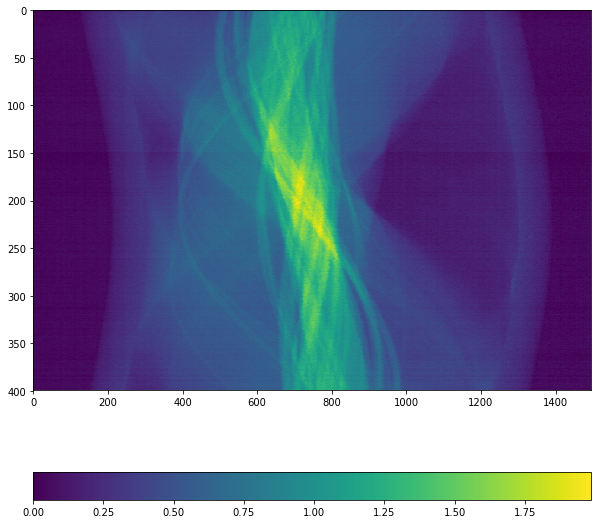

In [27]:
tmp_sinogram = sinogram[np.argsort(uniq_angles),:,int(sinogram.shape[-1]//2)+3]

plt.figure(figsize=(10,10))
plt.imshow(tmp_sinogram, cmap=plt.cm.viridis, interpolation='nearest')
plt.axis('tight')
plt.colorbar(orientation='horizontal')

In [28]:
import scipy.ndimage
def my_rc(sino0, level):
    def get_my_b(level):
        t= np.mean(sino0, axis=0)
        gt = scipy.ndimage.filters.gaussian_filter1d(t,level/2.)
        return gt-t
    
    def get_my_a(level):
        my_b = get_my_b(level)
        return np.mean(my_b)/my_b.shape[0]
    
    my_a = get_my_a(level)
    my_b = get_my_b(level)
    
    res = sino0.copy()
    if not level==0:
        res+= sino0*my_a+my_b
    
    return res

In [29]:
rc_level = 20

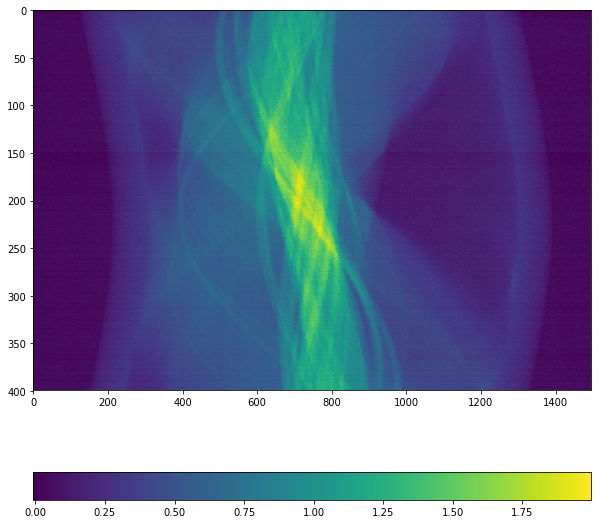

In [30]:
plt.figure(figsize=(10,10))
plt.imshow(my_rc(tmp_sinogram, rc_level), cmap=plt.cm.viridis, interpolation='nearest')
plt.axis('tight')
plt.colorbar(orientation='horizontal')

In [31]:
for s in tomotools.log_progress(range(sinogram.shape[1])):
    sinogram[:,s,:] = my_rc(sinogram[:,s,:], rc_level)

A Jupyter Widget

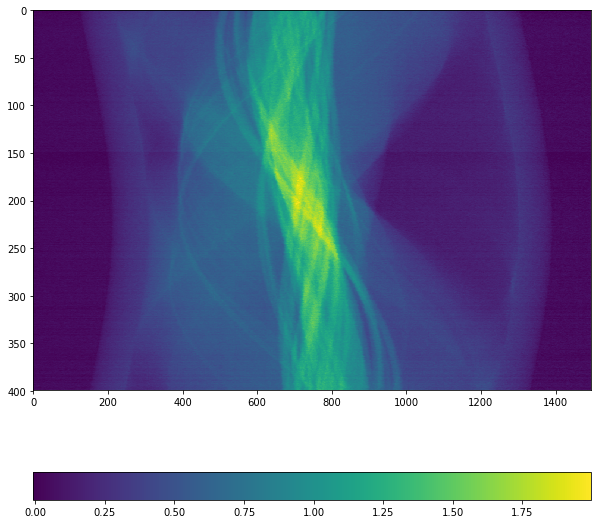

In [32]:
tmp_sinogram = sinogram[np.argsort(uniq_angles),:,int(sinogram.shape[-1]//2)+3]

plt.figure(figsize=(10,10))
plt.imshow(tmp_sinogram, cmap=plt.cm.viridis, interpolation='nearest')
plt.axis('tight')
plt.colorbar(orientation='horizontal')

In [33]:
# seraching detector rotation angle
for zero_angle in uniq_angles:
#     zero_angle = np.min(uniq_angles)
    position_0 = np.argwhere(np.isclose(uniq_angles, zero_angle, atol=0.05))[0][0]
    position_180 = np.argwhere(np.isclose(uniq_angles, 180+zero_angle, atol=0.05))
    if len(position_180)>0:
        position_180=position_180[0][0]
        print(uniq_angles[position_0], position_0)
        print(uniq_angles[position_180], position_180)
        break

def cv_rotate(x, angle):
    """
    Rotate square array using OpenCV2 around center of the array
    :param x: 2d numpy array
    :param angle: angle in degrees
    :return: rotated array
    """
    x_center = tuple(
        np.array((x.shape[1], x.shape[0]), dtype='float32') / 2.0 - 0.5)
    rot_mat = cv2.getRotationMatrix2D(x_center, angle, 1.0)
    xro = cv2.warpAffine(
        x, rot_mat, (x.shape[1], x.shape[0]), flags=cv2.INTER_LINEAR)
    return xro


data_0_orig = np.rot90(sinogram[position_0]).copy()
data_180_orig = np.rot90(sinogram[position_180]).copy()

0.0 0
180.0 189


In [34]:
def grad(x):
    return np.sqrt((np.diff(x, axis=0)**2)[:,:-1]+(np.diff(x, axis=1)**2)[:-1,:])

data_0 = cv2.medianBlur(data_0_orig,3)
data_180 = cv2.medianBlur(data_180_orig,3)

data_0 = grad(data_0)
data_180 = grad(data_180)

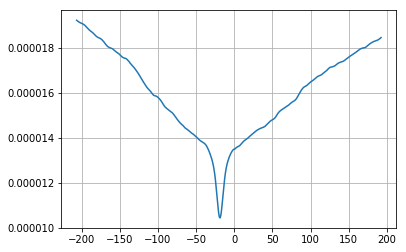

   direc: array([[ 1.        ,  0.        ],
       [-1.27917126, -3.95881547]])
     fun: 9.8953663664609582e-06
 message: 'Optimization terminated successfully.'
    nfev: 150
     nit: 4
  status: 0
 success: True
       x: array([  0.61661315, -18.53227489])


In [35]:
from scipy.optimize import minimize
from scipy.linalg import norm
# def f(x):
#     alfa= x[0]/10
#     shift = int(x[1]*10.)
#     if shift >= 0:
#         t = enp.fliplr(cv_rotate(data_180[:,shift:],alfa))-cv_rotate(data_0[:,shift:],alfa)
#     else:
#         t = np.fliplr(cv_rotate(data_180[:,:shift],alfa))-cv_rotate(data_0[:,shift],alfa)
        
#     res = np.sum(t*t)/np.prod(t.shape)
#     return res

def corr(x):
    alfa= x[0]/10.
    shift_x = int(x[1])
    if shift_x >= 0:
        t_180 = data_180[:,shift_x:]
        t_0 = data_0[:,shift_x:]
    else:
        t_180 = data_180[:,:shift_x]
        t_0 = data_0[:,:shift_x]
        
#     shift_y = int(x[2])//10
#     if shift_y > 0:
#         t_180 = t_180[shift_y:,:]
#         t_0 = t_0[:-shift_y,:]
#     elif shift_y < 0:
#         t_180 = t_180[:shift_y,:]
#         t_0 = t_0[-shift_y:,:]
    
    
#     t_mask = np.zeros_like(t_0)
#     shape_min = np.min(t_mask.shape)
#     r_mask = shape_min//2
#     X,Y = np.meshgrid(np.arange(t_mask.shape[1])-t_mask.shape[1]//2,
#                       np.arange(t_mask.shape[0])-t_mask.shape[0]//2)
#     t_mask = X**2+Y**2<r_mask**2    
    
    tt_180 = np.fliplr(cv_rotate(t_180,alfa))
    tt_180 = cv2.medianBlur(tt_180,5) #*t_mask
    tt_0 = cv_rotate(t_0,alfa)
    tt_0 = cv2.medianBlur(tt_0,5) #*t_mask
#     res = -np.correlate(tt_0.flat,tt_180.flat)
    res = np.mean((tt_0-tt_180)**2)**0.5*np.mean(np.abs(tt_0-tt_180))

    return res

s180 = data_180_orig.sum(axis=0)
r180 = np.flipud(np.arange(len(s180)))
p180 = (s180*r180).sum()/s180.sum()


s0 = data_0_orig.sum(axis=0)
r0 = np.arange(len(s0))
p0 = (s0*r0).sum()/s0.sum()

x0 = [1.,0.5*(p0-p180)]

qq = [corr([0,q]) for q in np.arange(x0[1]-200,x0[1]+200)]

plt.figure()
plt.plot(np.arange(x0[1]-200,x0[1]+200),qq)
plt.grid()
plt.show()
shift_0 = np.argmin(qq)-200
x0 = [1.,shift_0]
res= minimize(corr, x0, method='Powell')
print(res)

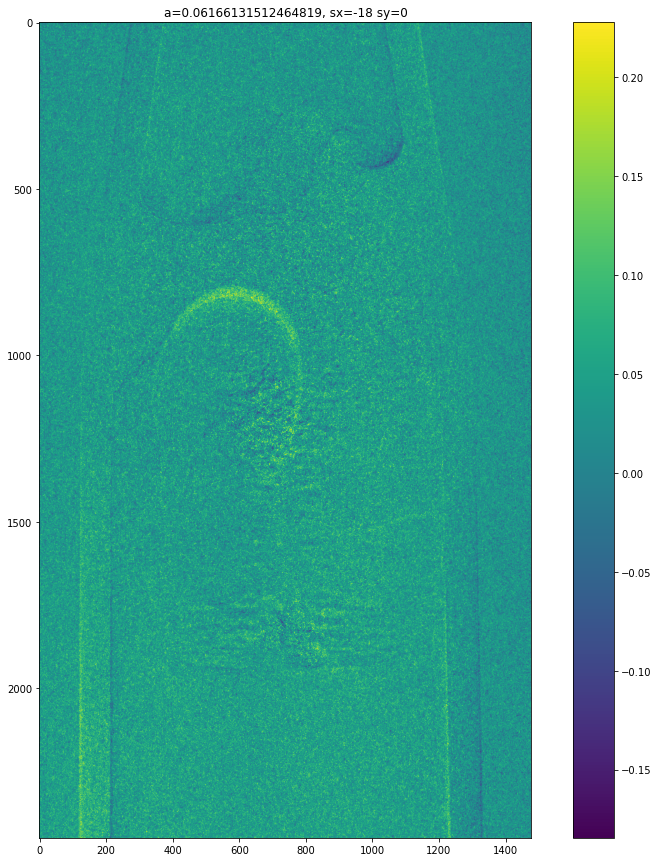

In [36]:
# alfa, shift_x, shift_y = res.x[0]/10, int(res.x[1]), int(res.x[2])//10

alfa, shift_x, shift_y = res.x[0]/10., int(res.x[1]), 0

if shift_x >= 0:
    t_180 = data_180_orig[:,shift_x:]
    t_0 = data_0_orig[:,shift_x:]
else:
    t_180 = data_180_orig[:,:shift_x]
    t_0 = data_0_orig[:,:shift_x]

if shift_y > 0:
    t_180 = t_180[shift_y:,:]
    t_0 = t_0[:-shift_y,:]
elif shift_y < 0:
    t_180 = t_180[:shift_y,:]
    t_0 = t_0[-shift_y:,:]
    
    
tt_180 = np.fliplr(cv_rotate(t_180,alfa))
tt_0 = cv_rotate(t_0,alfa)
    
plt.figure(figsize=(15,15))
plt.imshow(tt_180-tt_0, cmap=plt.cm.viridis)
plt.title('a={}, sx={} sy={}'.format(alfa,shift_x, shift_y))
plt.colorbar()
plt.show()

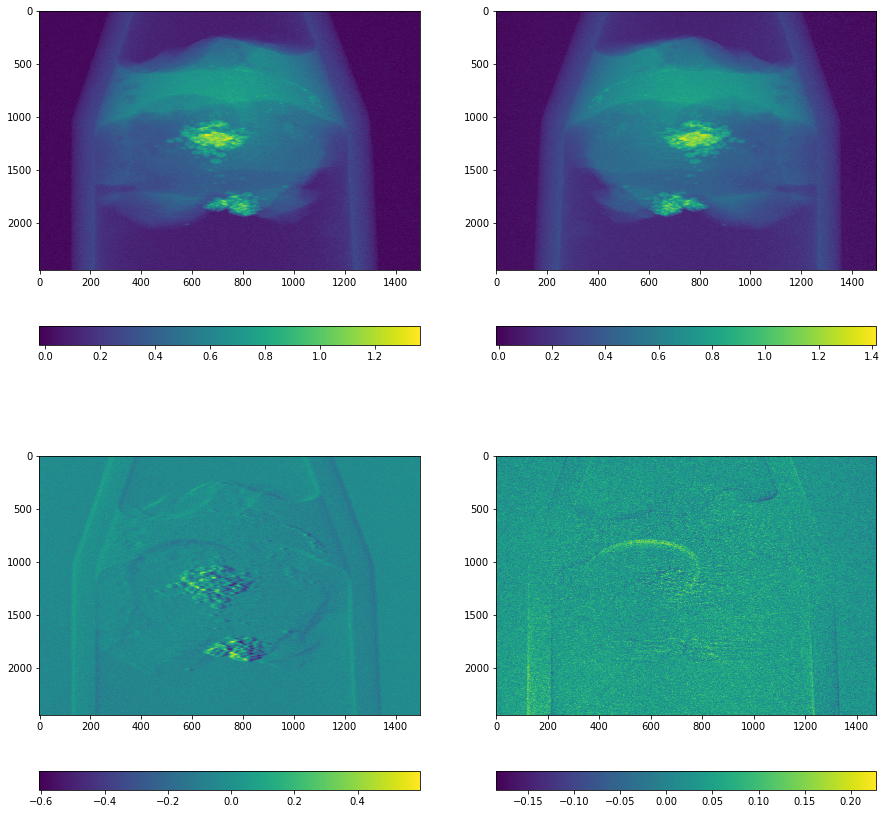

In [37]:
plt.figure(figsize=(15,15))
plt.subplot(221)
plt.imshow(data_0_orig,cmap=plt.cm.viridis)
plt.axis('tight')
plt.colorbar(orientation='horizontal')
plt.subplot(222)
plt.imshow(data_180_orig,cmap=plt.cm.viridis)
plt.axis('tight')
plt.colorbar(orientation='horizontal')
plt.subplot(223)
plt.imshow(data_0_orig - np.fliplr(data_180_orig),cmap=plt.cm.viridis)
plt.axis('tight')
plt.colorbar(orientation='horizontal')
plt.subplot(224)
# alfa = 0.1
# shift = -77
plt.imshow(tt_180-tt_0, cmap=plt.cm.viridis)
plt.axis('tight')
plt.colorbar(orientation='horizontal')

In [38]:
sinogram_fixed, _ = tomotools.load_create_mm(os.path.join(tmp_dir,'sinogram_fixed.tmp'),
                                shape=(sinogram.shape[0], sinogram.shape[1]-abs(shift_x),sinogram.shape[2]),
                                dtype='float32', force_create=True)

#fix axis tlit
for i in range(sinogram.shape[0]):
    t = sinogram[i].copy()
    if shift_x > 0:
        t = t[shift_x:]
    elif shift_x < 0:
        t = t[:shift_x]
    t_angle = uniq_angles[i]
    
    if not shift_y ==0 :
        delta_angle = t_angle - uniq_angles[position_0]+90
        tmp_shift_y = int(np.sin(delta_angle/180.*np.pi)*shift_y)
        t = np.roll(t, -tmp_shift_y, -1)
        t[:,0:np.abs(shift_y)]=0
        t[:,-np.abs(shift_y):]=0
        
    t = cv_rotate(t, alfa)
    sinogram_fixed[i] = t
    
# del sinogram

INFO:root:Force create
INFO:root:Creating new file: /diskmnt/fast/makov/robotom/3594d54a-060a-480c-b258-48e73ea047e6/sinogram_fixed.tmp


In [39]:
s1 = np.require(sinogram_fixed[...,int(sinogram_fixed.shape[-1]/1.5)],
                dtype=np.float32, requirements=['C'])

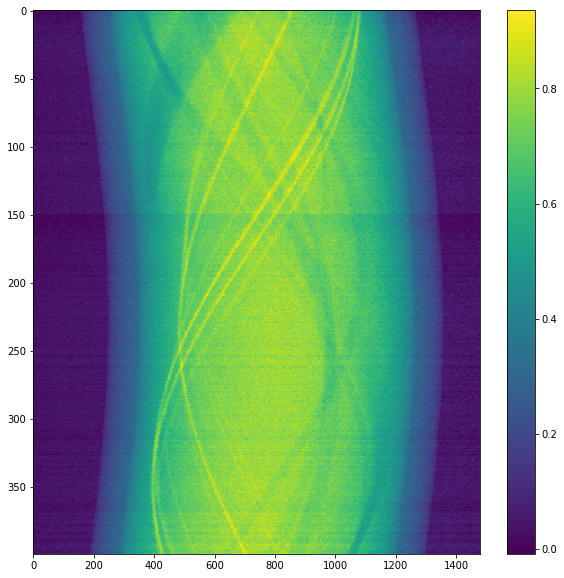

In [40]:
plt.figure(figsize=(10,10))
plt.imshow(sinogram_fixed[np.argsort(uniq_angles),:,int(sinogram_fixed.shape[-1]/1.5)], cmap=plt.cm.viridis)
plt.axis('tight')
plt.colorbar()
plt.show()

In [41]:
del sinogram_fixed

In [42]:
del data_0, data_180 ,tmp_sinogram, uniq_angles

In [43]:
del mask, t_0, t_180, zero_angle

In [44]:
uniq_angles, _ = tomotools.load_create_mm(os.path.join(tmp_dir,'uniq_angles.tmp'),
                             shape= None,
                             dtype='float32')
s1, _ = tomotools.load_create_mm(os.path.join(tmp_dir,'sinogram_fixed.tmp'),
                                shape= None,
                                dtype='float32')

rec_vol, _ = tomotools.load_create_mm(os.path.join(tmp_dir,'rec.tmp'),
               dtype=np.float32,
               shape = (s1.shape[-1],s1.shape[1],s1.shape[1]))



INFO:root:Loading existing file: /diskmnt/fast/makov/robotom/3594d54a-060a-480c-b258-48e73ea047e6/uniq_angles.tmp
INFO:root:Loading existing file: /diskmnt/fast/makov/robotom/3594d54a-060a-480c-b258-48e73ea047e6/sinogram_fixed.tmp
INFO:root:Creating new file: /diskmnt/fast/makov/robotom/3594d54a-060a-480c-b258-48e73ea047e6/rec.tmp


In [45]:
pixel_size = 9e-3
def astra_tomo2d_parallel(sinogram, angles):
    astra.astra.set_gpu_index([1,])
    angles = angles.astype('float64')
    detector_size = sinogram.shape[1]
    

    rec_size = detector_size
    vol_geom = astra.create_vol_geom(rec_size, rec_size)
    proj_geom = astra.create_proj_geom('parallel', 1.0, detector_size, angles)


    sinogram_id = astra.data2d.create('-sino', proj_geom, data=sinogram)
    # Create a data object for the reconstruction
    rec_id = astra.data2d.create('-vol', vol_geom)
#     proj_id = astra.create_projector('strip', proj_geom, vol_geom) # for CPU reconstruction only
    # Set up the parameters for a reconstruction algorithm using the GPU
    cfg = astra.astra_dict('FBP_CUDA')
    cfg['ReconstructionDataId'] = rec_id
    cfg['ProjectionDataId'] = sinogram_id
#     cfg['ProjectorId'] = proj_id # for CPU reconstruction only
    cfg['option'] = {}
    
    alg_id = astra.algorithm.create(cfg)
    astra.algorithm.run(alg_id, 1)
    
    cfg = astra.astra_dict('CGLS_CUDA')
    cfg['ReconstructionDataId'] = rec_id
    cfg['ProjectionDataId'] = sinogram_id
#     cfg['ProjectorId'] = proj_id # for CPU reconstruction only
    cfg['option'] = {}
#     cfg['option']['MinConstraint'] = -0.01

    alg_id = astra.algorithm.create(cfg)
    
    # Run 150 iterations of the algorithm
    astra.algorithm.run(alg_id, 10)
    
    # Get the result
    rec = astra.data2d.get(rec_id)/pixel_size  #fixit
    
    # Clean up. Note that GPU memory is tied up in the algorithm object,
    # and main RAM in the data objects.
    astra.algorithm.delete(alg_id)
    astra.data2d.delete(rec_id)
    astra.data2d.delete(sinogram_id)
    astra.clear()
    return rec

def astra_tomo3d_parallel(sinogram, angles, rec_vol, slice_start, slice_stop):
    astra.astra.set_gpu_index([1,])
    angles = angles.astype('float64')
    detector_size = sinogram.shape[1]
#         slices_number = sinogram.shape[0]
    slices_number = slice_stop - slice_start
        
    rec_size = detector_size
    vol_geom = astra.create_vol_geom(rec_size, rec_size, slices_number)
    proj_geom = astra.create_proj_geom('parallel3d', 1.0, 1.0,  slices_number, detector_size, angles)


    sinogram_id = astra.data3d.create('-sino', proj_geom, np.rollaxis(sinogram,-1)[slice_start:slice_stop])
    # Create a data object for the reconstruction
#     rec_id = astra.data3d.link('-vol', vol_geom, rec_vol[slice_start:slice_stop])
    rec_id = astra.data3d.create('-vol', vol_geom)
    # Set up the parameters for a reconstruction algorithm using the GPU
    cfg = astra.astra_dict('CGLS3D_CUDA')
    cfg['ReconstructionDataId'] = rec_id
    cfg['ProjectionDataId'] = sinogram_id
#     cfg['ProjectorId'] = proj_id # for CPU reconstruction only
    cfg['option'] = {}
#     cfg['option']['GPUindex'] = 1
    cfg['option']['MinConstraint'] = -0.01

    # Available algorithms:
    # SIRT_CUDA, SART_CUDA, EM_CUDA, FBP_CUDA (see the FBP sample)

    # Create the algorithm object from the configuration structure
    alg_id = astra.algorithm.create(cfg)
#     astra.data3d.info()
    # Run 150 iterations of the algorithm
    astra.algorithm.run(alg_id, 30)
    
    # Get the result
    rec = astra.data3d.get(rec_id)/pixel_size  #fixit

    # Clean up. Note that GPU memory is tied up in the algorithm object,
    # and main RAM in the data objects.
    astra.algorithm.delete(alg_id)
    astra.data3d.delete(rec_id)
    astra.data3d.delete(sinogram_id)
    astra.clear()
    return rec

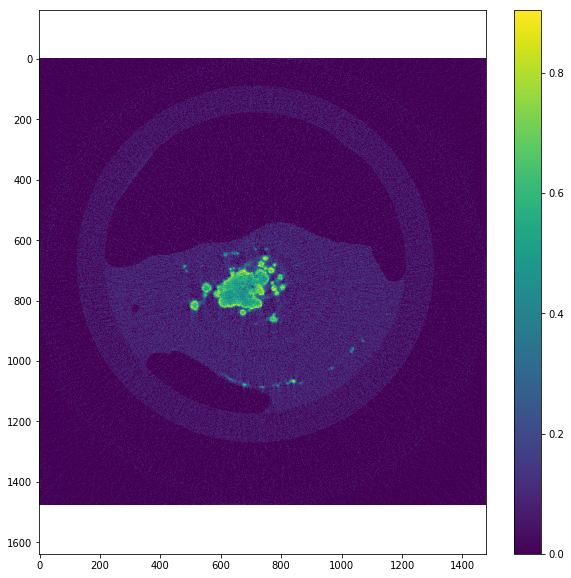

In [46]:
# %%timeit
#preview
sss = s1[...,int(s1.shape[-1]/2)]
t_angles = (uniq_angles-uniq_angles.min())<=180 # remove angles >180
rec_slice = astra_tomo2d_parallel(sss[t_angles], uniq_angles[t_angles]*np.pi/180)

plt.figure(figsize=(10,10))
plt.imshow(rec_slice, vmin=0)
plt.axis('equal')
plt.colorbar()
plt.show()

In [47]:
#multi 2d case
t = time.time()
print(s1.shape)
t_angles = (uniq_angles-uniq_angles.min())<=180  # remove angles >180
angles =np.array(uniq_angles)*np.pi/180
# for i in log_progress(range(1500, 1700, step)):
for i in tomotools.log_progress(range(0, s1.shape[-1])):
    sino = s1[t_angles,:,i]
    rec_vol[i] = astra_tomo2d_parallel(sino, angles[t_angles])
print(time.time()-t)

(400, 1478, 2450)


A Jupyter Widget

526.0109877586365


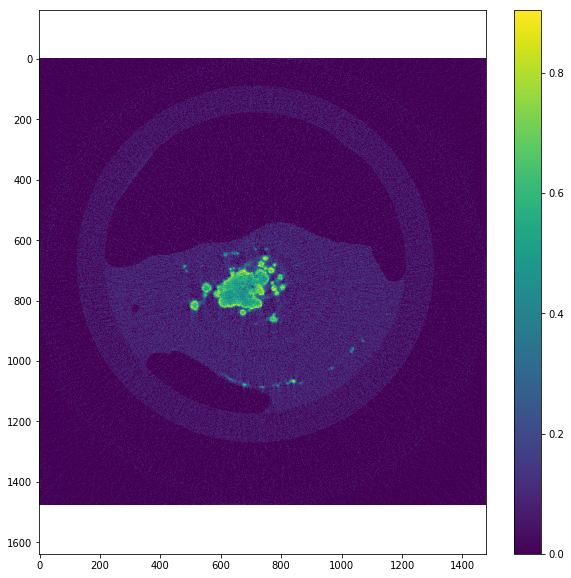

In [48]:
plt.figure(figsize=(10,10))
plt.imshow(rec_vol[int(rec_vol.shape[0]/2)], cmap=plt.cm.viridis, vmin=0)
plt.axis('equal')
plt.colorbar()
plt.show()

In [49]:
rec_vol_filtered, _ = tomotools.load_create_mm(os.path.join(tmp_dir,'rec_filtered.tmp'),
               dtype=np.float32,
               shape = rec_vol.shape)

INFO:root:Creating new file: /diskmnt/fast/makov/robotom/3594d54a-060a-480c-b258-48e73ea047e6/rec_filtered.tmp


In [50]:
t = time.time()
print(rec_vol.shape)
step = 200
angles =np.array(uniq_angles)*np.pi/180
# for i in log_progress(range(1500, 1700, step)):
for i in tomotools.log_progress(range(0, rec_vol.shape[0], step)):
    slice_start= i 
    slice_stop= min(i+step, s1.shape[-1])
    rec_vol_filtered[slice_start:slice_stop] = tomopy.remove_ring(
        rec_vol[slice_start:slice_stop],
        thresh=0.0005,  theta_min=90, rwidth=10)
print(time.time()-t)

(2450, 1478, 1478)


A Jupyter Widget

199.9968979358673


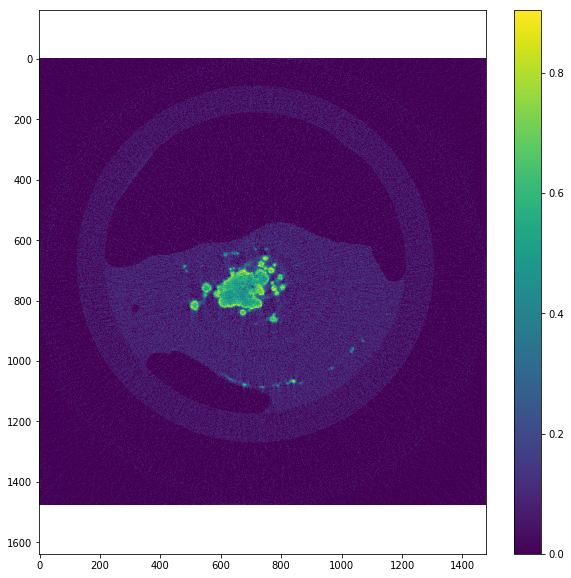

In [51]:
plt.figure(figsize=(10,10))
plt.imshow(rec_vol_filtered[int(rec_vol_filtered.shape[0]/2)], cmap=plt.cm.viridis, vmin=0)
plt.axis('equal')
plt.colorbar()
plt.show()

In [52]:
# rec_vol_filtered_size = np.loadtxt(os.path.join(tmp_dir,'rec_filtered.tmp.size')).astype('uint32')
# rec_vol_filtered, _ = tomotools.load_create_mm(os.path.join(tmp_dir,'rec_filtered.tmp'),
#                dtype=np.float32,
#                shape = tuple(rec_vol_filtered_size))

In [53]:
# %%timeit 
# denoise = denoise_nl_means(noisy, h=1.5 * sigma_est, fast_mode=True,
#                            **patch_kw)

/home/makov/opt/anaconda/envs/tomo/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


estimated noise standard deviation = 0.0042842367589682444


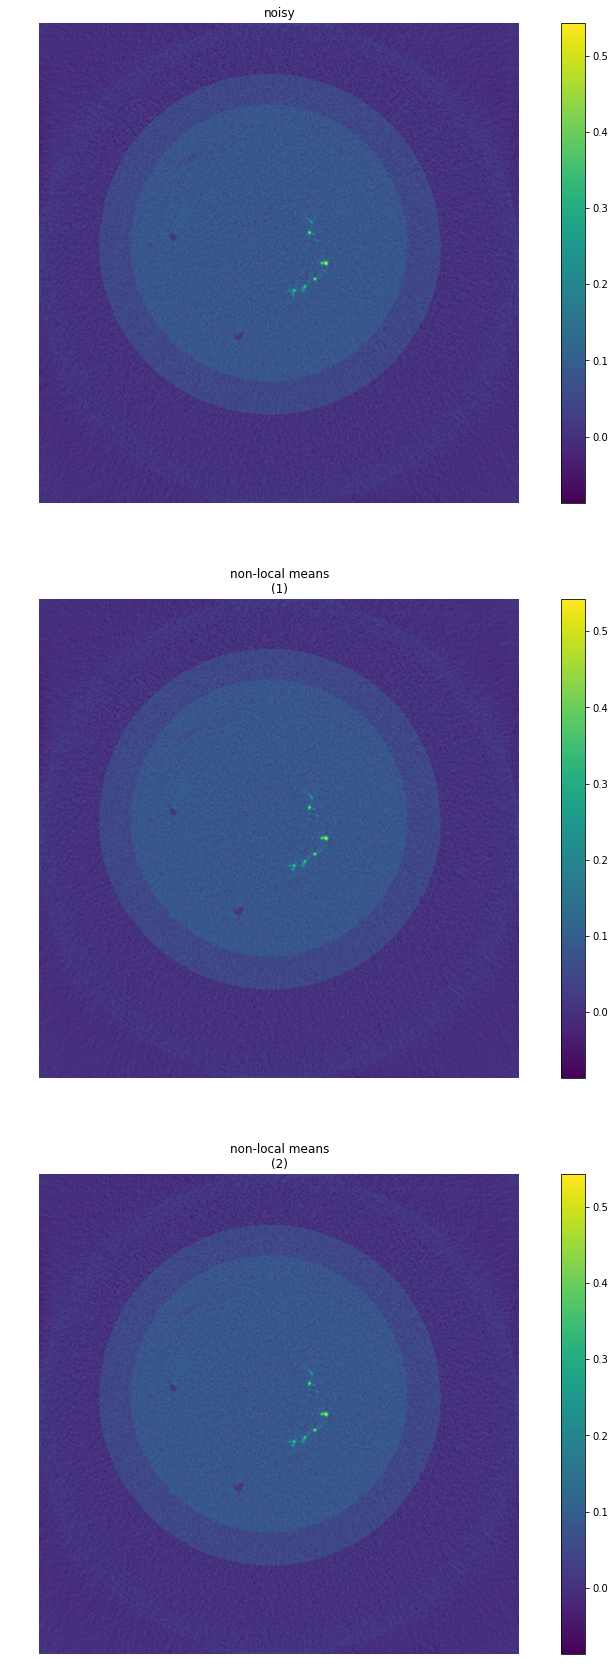

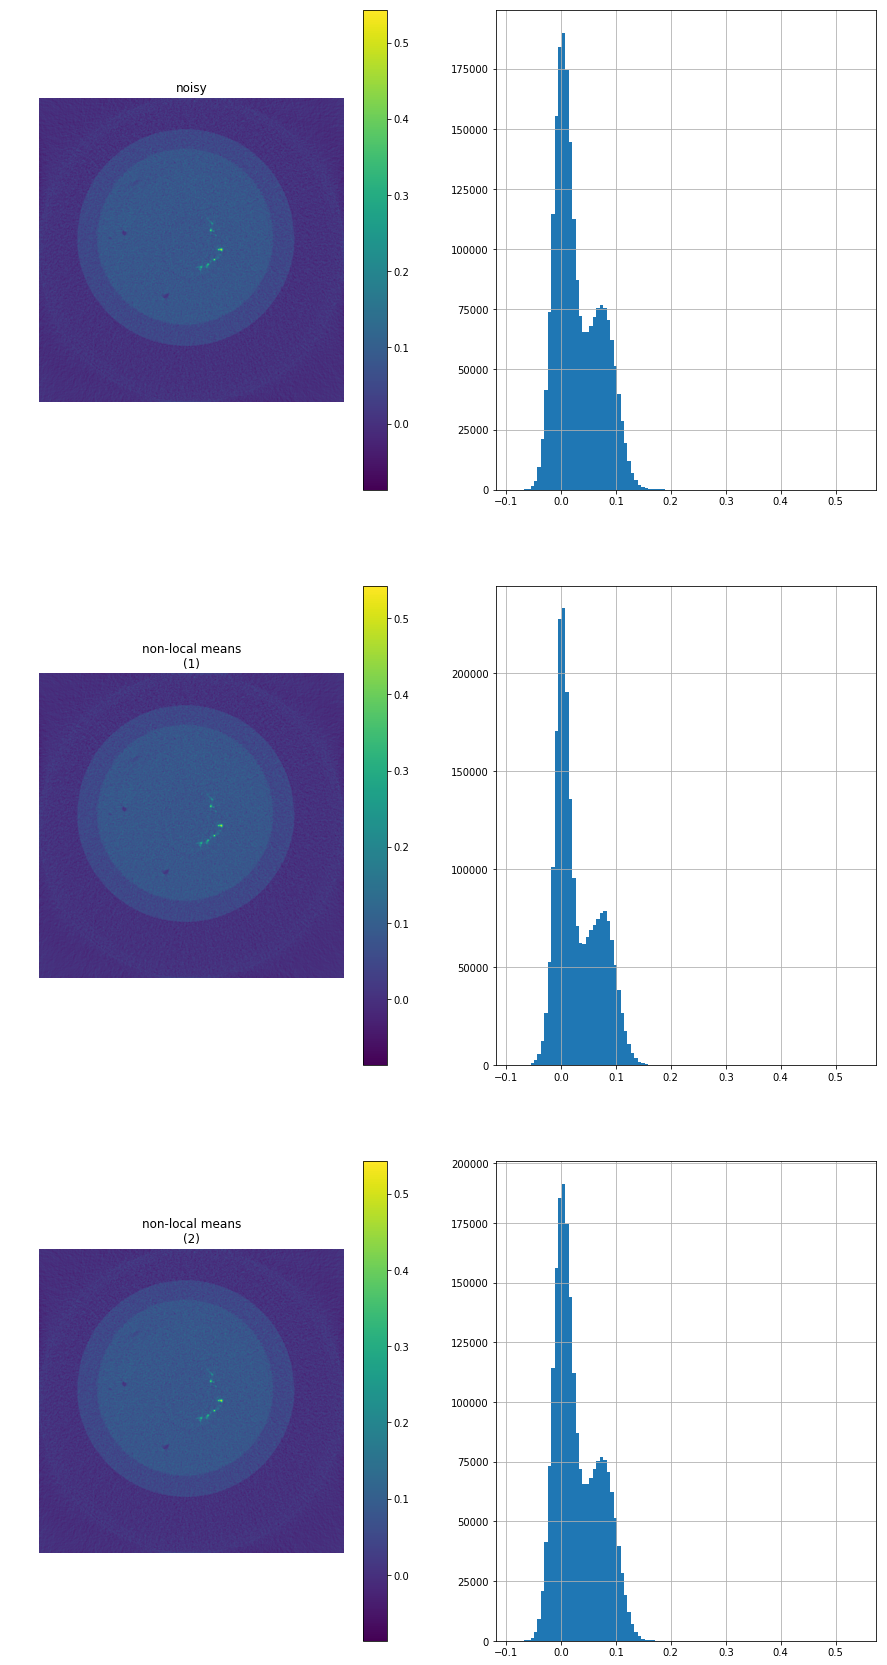

In [54]:
noisy = rec_vol_filtered[int(rec_vol_filtered.shape[0]*0.75)].astype('float64')
noisy = resize(noisy, (noisy.shape[0]//1, noisy.shape[1]//1))
# noisy = rec_vol_filtered[int(rec_vol_filtered.shape[0]*0.75)][::1,::1]
sigma_est = np.mean(estimate_sigma(noisy, multichannel=False))
print("estimated noise standard deviation = {}".format(sigma_est))

patch_kw = dict(patch_size=7,      # 5x5 patches
                patch_distance=15,  # 13x13 search area
                multichannel=False)

# 1 algorithm
denoise = denoise_nl_means(noisy, h=1.5 * sigma_est, fast_mode=True,
                           **patch_kw)



# 2 algorithm
denoise_fast = denoise_nl_means(noisy,  h=0.8 * sigma_est, fast_mode=True,
                                **patch_kw)


plt.figure(figsize=(15, 30))
plt.subplot(311)
plt.imshow(noisy, interpolation='bilinear')
plt.axis('off')
plt.colorbar()
plt.title('noisy')

plt.subplot(312)
plt.imshow(denoise, interpolation='bilinear')
plt.axis('off')
plt.colorbar()
plt.title('non-local means\n(1)')

plt.subplot(313)
plt.imshow(denoise_fast, interpolation='bilinear')
plt.axis('off')
plt.colorbar()
plt.title('non-local means\n(2)')

plt.show()

plt.figure(figsize=(15, 30))
plt.subplot(321)
plt.imshow(noisy, interpolation='bilinear')
plt.axis('off')
plt.colorbar()
plt.title('noisy')

plt.subplot(322)
plt.hist(noisy.ravel(), bins=100);
plt.grid()

plt.subplot(323)
plt.imshow(denoise, interpolation='bilinear')
plt.axis('off')
plt.colorbar()
plt.title('non-local means\n(1)')

plt.subplot(324)
plt.hist(denoise.ravel(), bins=100);
plt.grid()

plt.subplot(325)
plt.imshow(denoise_fast, interpolation='bilinear')
plt.axis('off')
plt.colorbar()
plt.title('non-local means\n(2)')

plt.subplot(326)
plt.hist(denoise_fast.ravel(), bins=100);
plt.grid()

plt.show()

In [55]:
# def denoise_slice(args):
#     rec_vol_filtered, slice_number = agrs
#     noisy = rec_vol_filtered[slice_number]
#     sigma_est = np.mean(estimate_sigma(noisy, multichannel=False))
#     patch_kw = dict(patch_size=3,      # 5x5 patches
#                 patch_distance=7,  # 13x13 search area
#                 multichannel=False)

#     denoise = denoise_nl_means(noisy, h=1.2 * sigma_est, fast_mode=True,
#                            **patch_kw)
#     rec_vol_filtered[slice_number] = noisy
    
# from multiprocessing import Pool, cpu_count
# p = Pool(processes=cpu_count())
# p.map(denoise_slice,[(rec_vol_filtered, i) for i in range(rec_vol_filtered.shape[0])])

In [56]:
def save_amira(in_array, out_path, reshape=3):
    data_path = out_path
    with open(os.path.join(data_path, 'amira.raw'), 'wb') as amira_file:
        in_array[::reshape,::reshape,::reshape].tofile(amira_file)
#         resize(in_array, (noisy.shape[0]//reshape, noisy.shape[1]//reshape))
        file_shape = in_array[::reshape,::reshape,::reshape].shape
        with open(os.path.join(data_path, 'tomo.hx'), 'w') as af:
                af.write('# Amira Script\n')
                af.write('remove -all\n')
                af.write(r'[ load -raw ${SCRIPTDIR}/amira.raw little xfastest float 1 '+
                         str(file_shape[1])+' '+str(file_shape[2])+' '+str(file_shape[0])+
                         ' 0 '+str(file_shape[1]-1)+' 0 '+str(file_shape[2]-1)+' 0 '+str(file_shape[0]-1)+
                         ' ] setLabel tomo.raw\n')


In [57]:
save_amira(rec_vol_filtered, tmp_dir)

In [58]:
storage_dir = '/diskmnt/a/makov/robotom/'

In [59]:
files_to_remove =  ['data_images_clear.tmp','data_images_masked.tmp',
                    'empty_images_masked.tmp',
                    'uniq_data_images.tmp','sinogram.tmp',
                    'group_empty.tmp','group_empty_angles.tmp',
                    'group_dark.tmp','group_dark_angles.tmp',
                    'group_data.tmp','group_data_angles.tmp',
                    'rec.tmp', 'rec_filtered.tmp',
                    'sinogram_fixed.tmp', 'uniq_angles.tmp']
for fr in files_to_remove:
    try:
        os.remove(os.path.join(tmp_dir,fr))
    except:
        pass
    try:
        os.remove(os.path.join(tmp_dir,fr+'.size'))
    except:
        pass


In [60]:
tomotools.mkdir_p(os.path.join(storage_dir, experiment_id))

In [61]:
!cp 'tomo.ini'  {os.path.join(storage_dir, experiment_id)}

In [62]:
!cp -r {os.path.join(data_dir, experiment_id)} {storage_dir}

In [63]:
!rm -rf {os.path.join(data_dir, experiment_id)}

In [64]:
!mv {os.path.join(data_dir, experiment_id+'.h5')} {storage_dir}